# How to create epochs

So, in your experiment, participants undergo a number of trials (events) and these events are possibly of different conditions. And you are wondering how can you locate these events on your signals and perhaps make them into epochs for future analysis?

This example shows how to use Neurokit to extract epochs from data based on events localisation. In case you have multiple data files for each subject, this example also shows you how to create a loop through the subject folders and put the files together in an epoch format for further analysis.

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images

In this example, we will use a short segment of data which has ECG, EDA and respiration (RSP) signals.

## One signal with multiple event markings

In [11]:
# Retrieve ECG data from data folder (sampling rate= 1000 Hz)
data = nk.data("bio_eventrelated_100hz")

Besides the signal channels, this data also has a fourth channel which consists of a string of 0 and 5. This is a binary marking of the Digital Input channel in BIOPAC. 

Let's visualize the event-marking channel below.

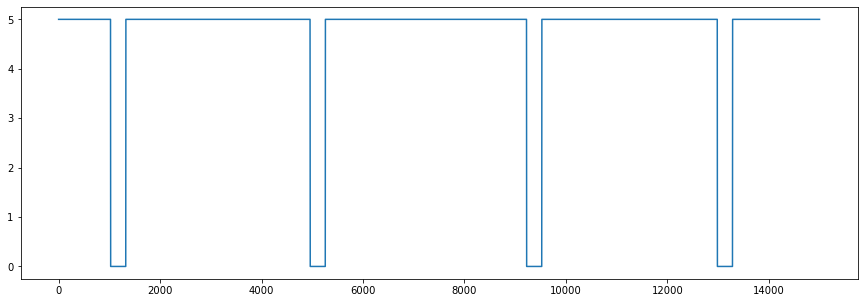

In [12]:
# Visualize the event-marking channel
plt.plot(data['Photosensor'])

Depends on how you set up your experiment, the onset of the event can either be marked by signal going from 0 to 5 or vice versa. Specific to this data, the onsets of the events are marked where the signal in the event-marking channel goes from 5 to 0 and the offsets of the events are marked where the signal goes from 0 to 5.

As shown in the above figure, there are four times the signal going from 5 to 0, corresponding to the 4 events (4 trials) in this data.  

There were 2 types (the condition) of images that were shown to the participant: “Negative” vs. “Neutral” in terms of emotion. Each condition had 2 trials. The following list is the condition order.

In [13]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

Before we can epoch the data, we have to locate the events and extract their related information. This can be done using Neurokit function [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find>).

In [14]:
# Find events
events = nk.events_find(event_channel=data["Photosensor"], 
                        threshold_keep='below', 
                        event_conditions=condition_list)

events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

The output of [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find>) gives you a `dictionary` that contains the information of event onsets, event duration, event label and event condition. 

As stated, as the event onsets of this data are marked by event channel going from 5 to **0**, the `threshold_keep` is set to `below`. Depends on your data, you can customize the `arguments` in [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find>) to correctly locate the events. 

You can use the [events_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_plot>) function to plot the events that have been found together with your event channel to confirm that it is correct.

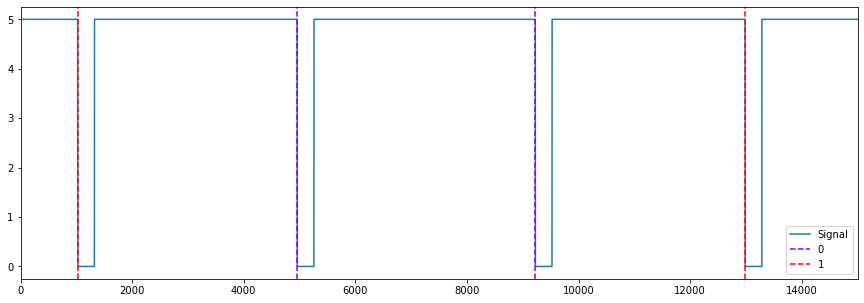

In [15]:
plot = nk.events_plot(events, data['Photosensor'])

Or you can visualize the events together with the all other signals.

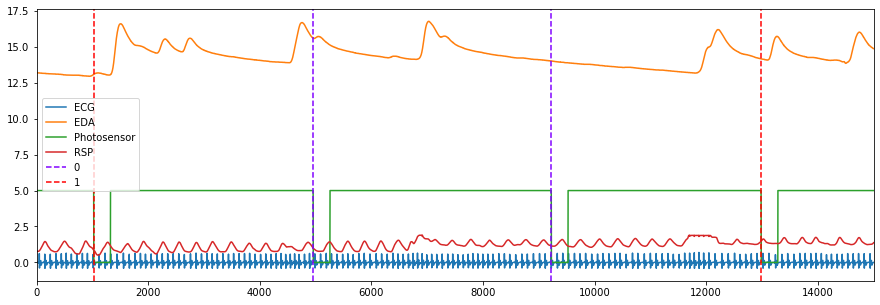

In [16]:
plot = nk.events_plot(events, data)

After you have located the events, you can now create epochs using the NeuroKit [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create>) function. However, we recommend to process your signal first before cutting them to smaller epochs. You can read more about processing of physiological signals using NeuroKit in [Custom your Processing Pipeline](https://neurokit2.readthedocs.io/en/latest/examples/custom.html>) Example.

In [19]:
# Process the signal
df, info = nk.bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], sampling_rate=100)

Now, let's think about how we want our epochs to be like. For this example, we want:
  
    1. Epochs to start *1 second before the event onset*

    2. Epochs to end *6 seconds* afterwards

These are passed into the `epochs_start` and `epochs_end` arguments, respectively. 

Our epochs will then cover the region from **-1 s** to **+6 s** relative to the onsets of events (i.e., 700 data points since the signal is sampled at 100Hz).

In [20]:
# Build and plot epochs
epochs = nk.epochs_create(df, events, sampling_rate=100, epochs_start=-1, epochs_end=6)

And as easy as that, you have created a dictionary of four dataframes, each correspond to an epoch of the event. 

Here, in the above example, all your epochs have the same starting time and ending time, specified by `epochs_start` and `epochs_end`. Nevertheless, you can also pass a list of different timings to these two arguments to customize the duration of the epochs for each of your events. 

## One subject with multiple data files

In some experimental designs, instead of having one signal file with multiple events, each subject can have multiples files where each file is the record of one event. 

In the following example, we will show you how to create a loop through the subject folders and put the files together in an epoch format for further analysis. 

Firstly, let's say your data is arranged as the following where each subject has a folder and in each folder there are multiple data files corresponding to different events:

```
[Experiment folder]
|
└── Data
|   |
|   └── Subject_001/
|   |   │   event_1.[csv]
|   |   │   event_2.[csv]
|   |   |__ ......
|   └── Subject_002/
|       │   event_1.[csv]
|       │   event_2.[csv]
|       |__ ......
└── analysis_script.py
```

The following will illustrate how your analysis script might look like. Try to re-create such data structure and the analysis script in your computer! 

Now, in our analysis scripts, let's load the necessary packages:

In [21]:
# Load packages
import pandas as pd
import os

Assuming that your working directory is now at your analysis script, and you want to read all the data files of `Subject_001`. 

Your analysis script should look something like below:

In [ ]:

# Your working directory should be at Experiment folder
participant = 'Subject_001'

sampling_rate=100

# List all data files in Subject_001 folder
all_files = os.listdir('Data/' + participant)

# Create an empty directory to store your files (events)
epochs = {}

# Loop through each file in the subject folder
for i, file in enumerate(all_files):
    # Read the file
    data = pd.read_csv('Data/' + participant + '/' + file)
    # Add a Label column (e.g Label 1 for epoch 1)
    data['Label'] = np.full(len(data), str(i+1))
    # Set index of data to time in seconds
    index = data.index/sampling_rate
    data = data.set_index(pd.Series(index))
    # Append the file into the dictionary
    epochs[str(i + 1)] = data
    
epochs

And tah dah! You now should have a `dictionary` called epochs that resembles the output of NeuroKit [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create>). Each `DataFrame` in the epochs corresponds to an event (a trial) that `Subject_001` underwent. 

The epochs is now ready for further analysis!